# First Approach: Denoising Process of the Disparity Map 

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imageio
import math
import matplotlib as mpl

### Getting the Left and Right images from a Stereo Camera

In [2]:
# get input images
imgL = cv.imread('Tsukuba_L.pgm',0)
imgR = cv.imread('Tsukuba_R.pgm',0)

### Getting the Disparity Map

In [6]:
# forces similar disparity on neighbouring blocks
stereo = cv.StereoSGBM_create(numDisparities=64, blockSize=15) 
# computes disparity map for the specified stereo pair.
disparity = stereo.compute(imgL,imgR)

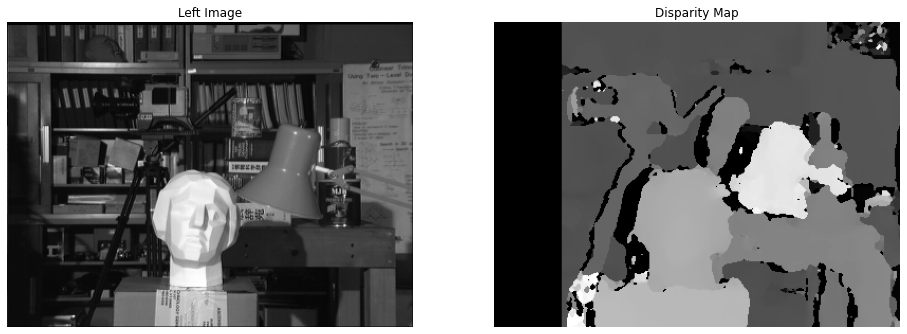

In [7]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(imgL, cmap="gray"); plt.title("Left Image")
plt.axis('off')
plt.subplot(122)
plt.imshow(disparity, cmap="gray"); plt.title("Disparity Map")
plt.axis('off')
plt.show()

### Kernel

In [8]:
# specified the kernel to perform filtering
kernel = np.ones((5,5),np.uint8) 

### Scaling and converting the Disparity Map to the required format

In [9]:
# get a Disparity Map in UINT8 format
maxDisp = np.max(disparity)
modDisparity = np.where(disparity<0,0,disparity)
modDisparity = np.array((modDisparity/maxDisp)*255,dtype=np.uint8)

### Erotion and Dilation of the Modified Disparity Map

In [16]:
# perform opening operation, so apply erotion first and to that result apply dilation
# erodes an image by using a specific structuring element
erosionMDP = cv.erode(modDisparity,kernel,iterations = 1)
# dilates an image by using a specific structuring element
dilationMDP = cv.dilate(erosionMDP,kernel,iterations = 2)

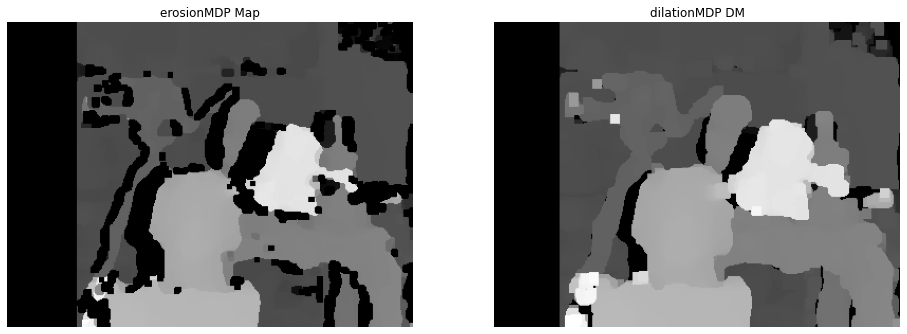

In [17]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(erosionMDP, cmap="gray"); plt.title("erosionMDP Map")
plt.axis('off')
plt.subplot(122)
plt.imshow(dilationMDP, cmap="gray"); plt.title("dilationMDP DM")
plt.axis('off')
plt.show()

### Denoising the Modified Disparity Map

In [20]:
# apply median filter to deal with noise in the image
# blurs an image using the median filter
denoisedDisp = cv.medianBlur(dilationMDP, 5)

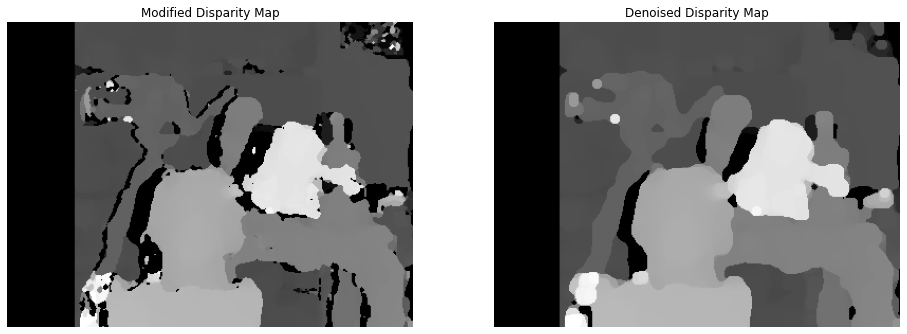

In [21]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(modDisparity, cmap="gray"); plt.title("Modified Disparity Map")
plt.axis('off')
plt.subplot(122)
plt.imshow(denoisedDisp, cmap="gray"); plt.title("Denoised Disparity Map")
plt.axis('off')
plt.show()

### Generating the required Mask for the Inpainting Process

In [22]:
# specified the aproppriate size of the mask 
r,c = modDisparity.shape
# create a mask to use with the Disparity Map without noise
mask = np.zeros((r,c), dtype=np.uint8)
mask = np.where(denoisedDisp<=10, 255, 0)
mask = np.array(mask,dtype=np.uint8)
# create a mask to use with the original Disparity Map with imperfections
maskInit = np.zeros((r,c), dtype=np.uint8)
maskInit = np.where(modDisparity==0, 255, 0)
maskInit = np.array(maskInit,dtype=np.uint8)

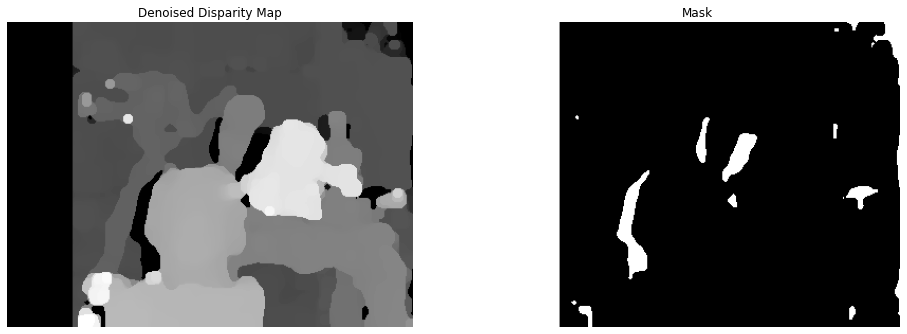

In [23]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(denoisedDisp, cmap="gray"); plt.title("Denoised Disparity Map")
plt.axis('off')
plt.subplot(122)
plt.imshow(mask, cmap="gray"); plt.title("Mask")
plt.axis('off')
plt.show()

### Inpainting Process with the Original Disparity Map

In [24]:
# restores the selected region in an image using the region neighborhood
dst = cv.inpaint(modDisparity,maskInit,9,cv.INPAINT_NS)

### Inpainting Process with the Enhaced (without noise) Disparity Map

In [25]:
# restores the selected region in an image using the region neighborhood
dstDDP = cv.inpaint(denoisedDisp,mask,9,cv.INPAINT_NS)

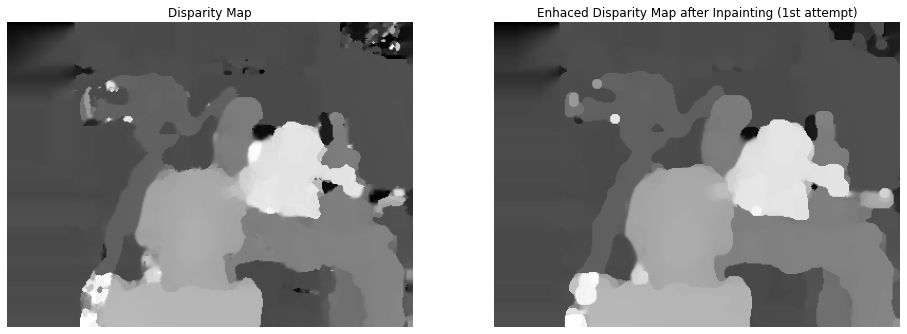

In [26]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(dst, cmap='gray'); plt.title("Disparity Map")
plt.axis('off')
plt.subplot(122)
plt.imshow(dstDDP, cmap='gray'); plt.title("Enhaced Disparity Map after Inpainting (1st attempt)")
plt.axis('off')
plt.show()

# Second Approach: Enhacement  Process of the Mask

### Getting edges

In [27]:
# modified the mask required by the inpainting algorithm to get 
# the object's borders well-defined after the inpainting

# finds edges in the input image and marks them in the output 
# map edges using the Canny algorithm
edges = cv.Canny(imgL,210,250) 

# apply inverse to mark the borders with black lines
edgesInv = np.where(edges==0,255,0)

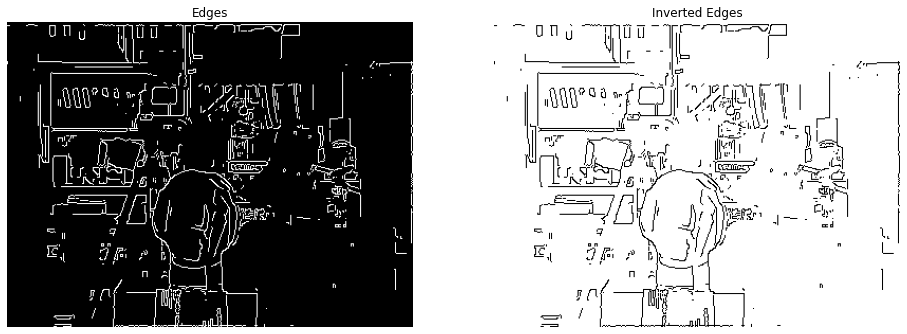

In [28]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(edges, cmap="gray"); plt.title("Edges")
plt.axis('off')
plt.subplot(122)
plt.imshow(edgesInv, cmap="gray"); plt.title("Inverted Edges")
plt.axis('off')
plt.show()

### Dilation process to improve border representation

In [29]:
# dilates the image of edges by using an specific structuring element
edgesDil = cv.dilate(edges,kernel,iterations = 1)
# apply inverse to mark the borders with black lines
edgesInvDil = np.where(edgesDil==0,255,0)

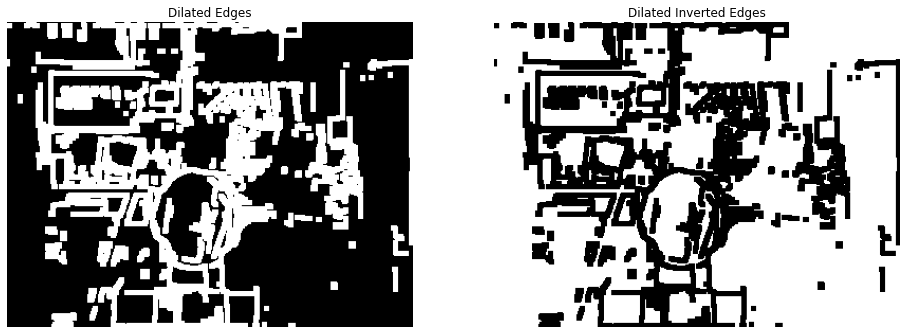

In [30]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(edgesDil, cmap="gray"); plt.title("Dilated Edges")
plt.axis('off')
plt.subplot(122)
plt.imshow(edgesInvDil, cmap="gray"); plt.title("Dilated Inverted Edges")
plt.axis('off')
plt.show()

### Combining the Inverted Dilated Edges image with the Mask

In [31]:
# create a new mask which allows a better representation of object's borders
# during the inpainting process
modMask = np.where(mask==255, edgesInvDil, mask)
modMask = np.array(modMask,dtype=np.uint8)

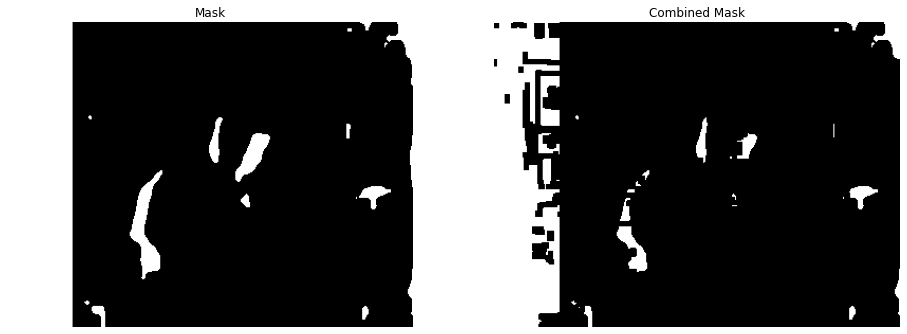

In [32]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask, cmap='gray'); plt.title("Mask")
plt.axis('off')
plt.subplot(122)
plt.imshow(modMask, cmap='gray'); plt.title("Combined Mask")
plt.axis('off')
plt.show()

### Inpainting Process with the Enhaced (without noise) Disparity Map and the Combined Mask

In [33]:
# restores the selected region in an image using the region neighborhood
dstPartial = cv.inpaint(denoisedDisp,modMask,9,cv.INPAINT_NS)

### Generating a simple Mask from the Partial Disparity Map

In [34]:
# create a new simple mask to perform inpainting with the partial map
finalMask = np.zeros((r,c), dtype=np.uint8)
finalMask = np.where(dstPartial<=30, 255, 0)
finalMask = np.array(finalMask,dtype=np.uint8)

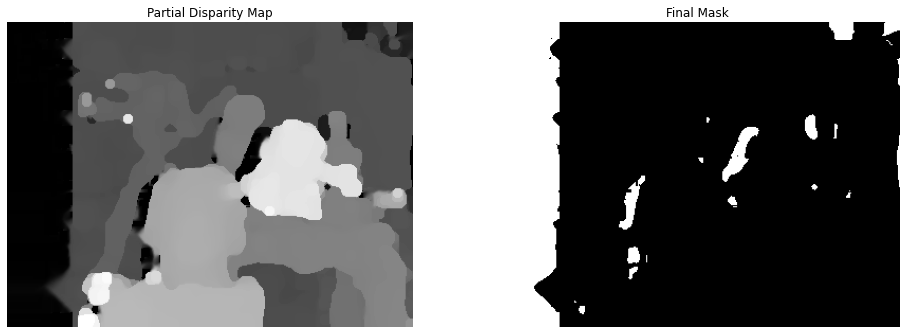

In [35]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(dstPartial, cmap='gray'); plt.title("Partial Disparity Map")
plt.axis('off')
plt.subplot(122)
plt.imshow(finalMask, cmap='gray'); plt.title("Final Mask")
plt.axis('off')
plt.show()

### Final Inpainting Process with the Partial Disparity Map and the Final Mask

In [36]:
# restores the selected region in an image using the region neighborhood
dstFinal = cv.inpaint(dstPartial,finalMask,3,cv.INPAINT_NS)

### Comparison between 1st and 2nd approach

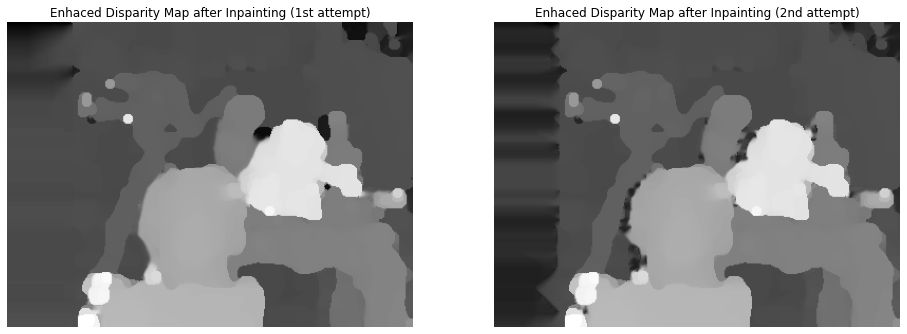

In [37]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(dstDDP, cmap='gray'); plt.title("Enhaced Disparity Map after Inpainting (1st attempt)")
plt.axis('off')
plt.subplot(122)
plt.imshow(dstFinal, cmap='gray'); plt.title("Enhaced Disparity Map after Inpainting (2nd attempt)")
plt.axis('off')
plt.show()

### Comparison between Original Disparity Map and FInal Disparity Map (2nd Approach)

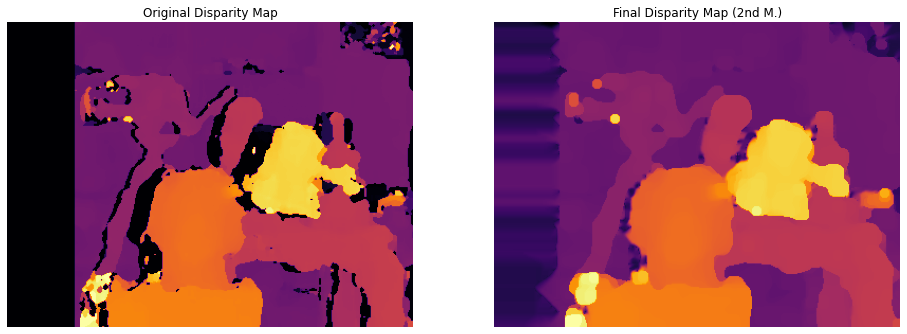

In [39]:
# plot the partial results
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(disparity, cmap="inferno"); plt.title("Original Disparity Map")
plt.axis('off')
plt.subplot(122)
plt.imshow(dstFinal, cmap="inferno"); plt.title("Final Disparity Map (2nd M.)")
plt.axis('off')
plt.show()